In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.SpaceMMiCRM, MLSolver

In [2]:
using CairoMakie, ProgressLogging
using Base.Threads
using BenchmarkTools

# Steven's layer model

## Basic no space solve

- 4 strains with 7 resources
- I'll make first the "glucose" which is all leaked

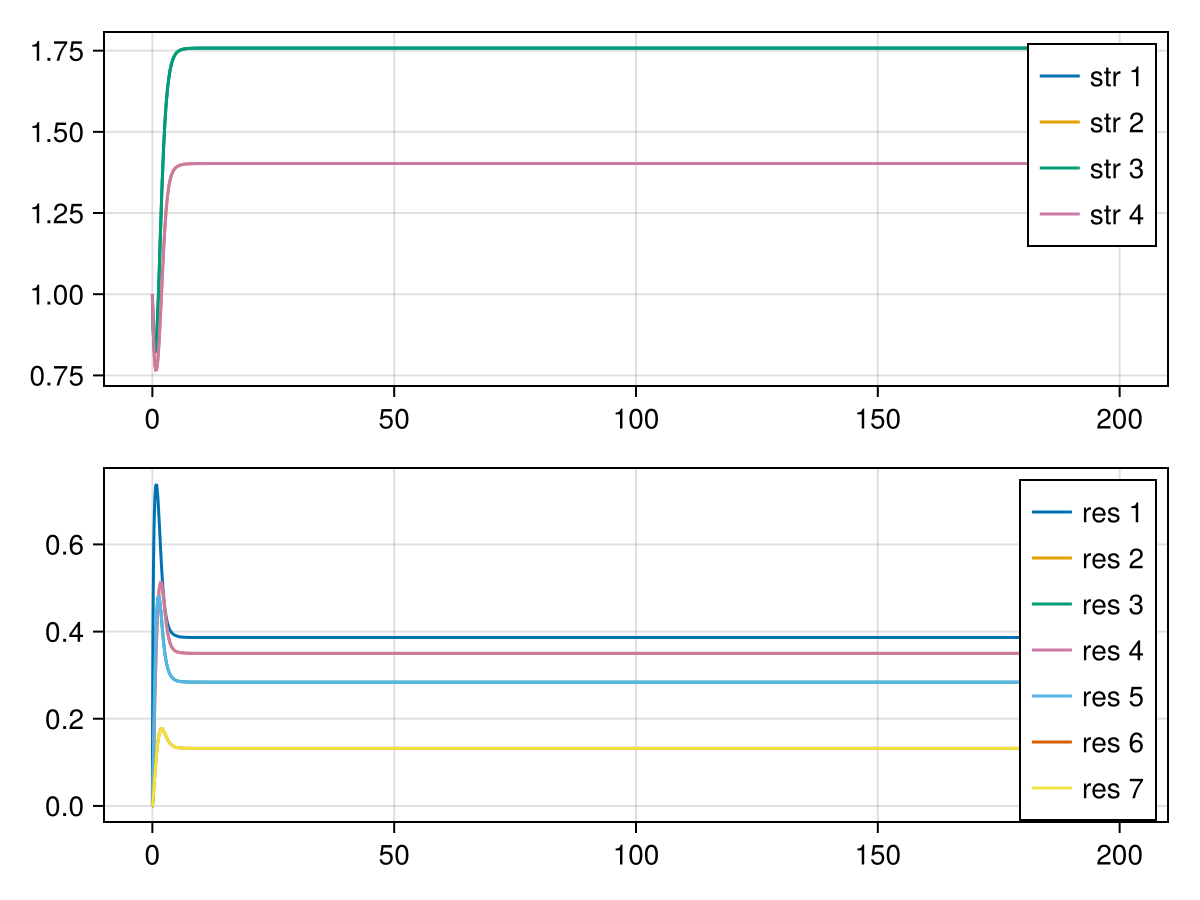

11-element Vector{Float64}:
 1.7579235174143404
 1.4024255637823093
 1.7579235174143404
 1.4024255637823093
 0.38635707264450014
 0.3499999999783131
 0.28399305866441665
 0.3499999999783131
 0.28399305866441665
 0.13201388260393268
 0.13201388260393268

In [4]:
l = fill(0., 4, 7)
c = fill(0., 4, 7)
c[:, 1] .= 2. # they all eat glucose
l[:, 1] .= 1. # and they leak all of it

D = fill(0., 4, 7, 7)
# 1-2 cross feeding
D[1, 2, 1] = 0.8
c[2, 2] = 2.
D[2, 3, 1] = 1.
c[1, 3] = 2.

# 3-4 cross feeding
D[3, 4, 1] = 0.8
c[4, 4] = 2.
D[4, 5, 1] = 1.
c[3, 5] = 2.

# 1-3 cross feeding
D[1, 6, 1] = 0.2
c[3, 6] = 1.
D[3, 7, 1] = 0.2
c[1, 7] = 1.

# display(l)
# display(c)
# display(D)
p = make_mmicrm_smart(4, 7, 200;
    D, l, c,
    K=[5., 0., 0., 0., 0., 0., 0.],
    r=fill(0.3, 7),
    m=fill(0.7, 4),
    u0=:onlyN,
    u0rand=0.
)
s = solve(p)
display(plot_mmicrm_sol(s))
s[end]
#param_summary(p.p)
# check_mmicrmparams(p.p)

#### Steady state solving

In [16]:
symsol = symbolic_solve_ode_ml(p)

┌ Warning: Solve::ratnz: Solve was unable to solve the system with inexact coefficients.
│     The answer was obtained by solving a corresponding exact system and
│     numericizing the result.
└ @ MathLink ~/.julia/packages/MathLink/S39uA/src/eval.jl:16


65-element Vector{Vector{Pair{Symbolics.Num, Complex{Symbolics.Num}}}}:
 [u1 => -0.0025988975085542093, u2 => 0.023669403378296625, u3 => -0.25658264915542583, u4 => 0.0, u5 => -29.235613843145874, u6 => 0.35, u7 => -4.694602179828955, u8 => 40.00720666431685, u9 => 0.0, u10 => 0.7, u11 => 10.08920435965791]
 [u1 => -0.25658264915542583, u2 => 0.0, u3 => -0.0025988975085542093, u4 => 0.023669403378296625, u5 => -29.235613843145874, u6 => 40.00720666431685, u7 => 0.0, u8 => 0.35, u9 => -4.694602179828955, u10 => 10.08920435965791, u11 => 0.7]
 [u1 => -0.15, u2 => 0.0, u3 => -0.15, u4 => 0.0, u5 => -16.666666666666668, u6 => 13.333333333333334, u7 => -2.9833333333333334, u8 => 13.333333333333334, u9 => -2.9833333333333334, u10 => 6.666666666666667, u11 => 6.666666666666667]
 [u1 => 0.0, u2 => 0.0, u3 => -0.3, u4 => 0.0, u5 => -16.666666666666668, u6 => 0.0, u7 => 0.0, u8 => 26.666666666666668, u9 => 0.0, u10 => 0.7, u11 => 6.666666666666667]
 [u1 => 0.0, u2 => -0.15, u3 => -0.15, u4 => 0

In [17]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[1.757923110083762, 1.402425241247472, 1.757923110083762, 1.402425241247472, 0.386357166944847, 0.35000011244227996, 0.28399314557178695, 0.35000011244227996, 0.28399314557178695, 0.1320139355150468, 0.1320139355150468]

## Linear stability analysis

In [5]:
ks = LinRange(0., 20., 1000)
Ds = [fill(1e-4, 4); 100; fill(1, 4); fill(10, 2)]
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[-1.1819222299879754e-10, -6.082845444635082e-11, -1.1819222299879754e-10, -6.082845444635082e-11, 2.3157475936841365e-11, 1.3522072350724557e-11, 3.2949643014035246e-11, 1.3522072350724557e-11, 3.2949643014035246e-11, 1.2642054070255426e-11, 1.2642054070255426e-11]

maximum(real(lambdas)) = 0.02284561420734905


[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.243212
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.243212
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.145465
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.145465
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.080949


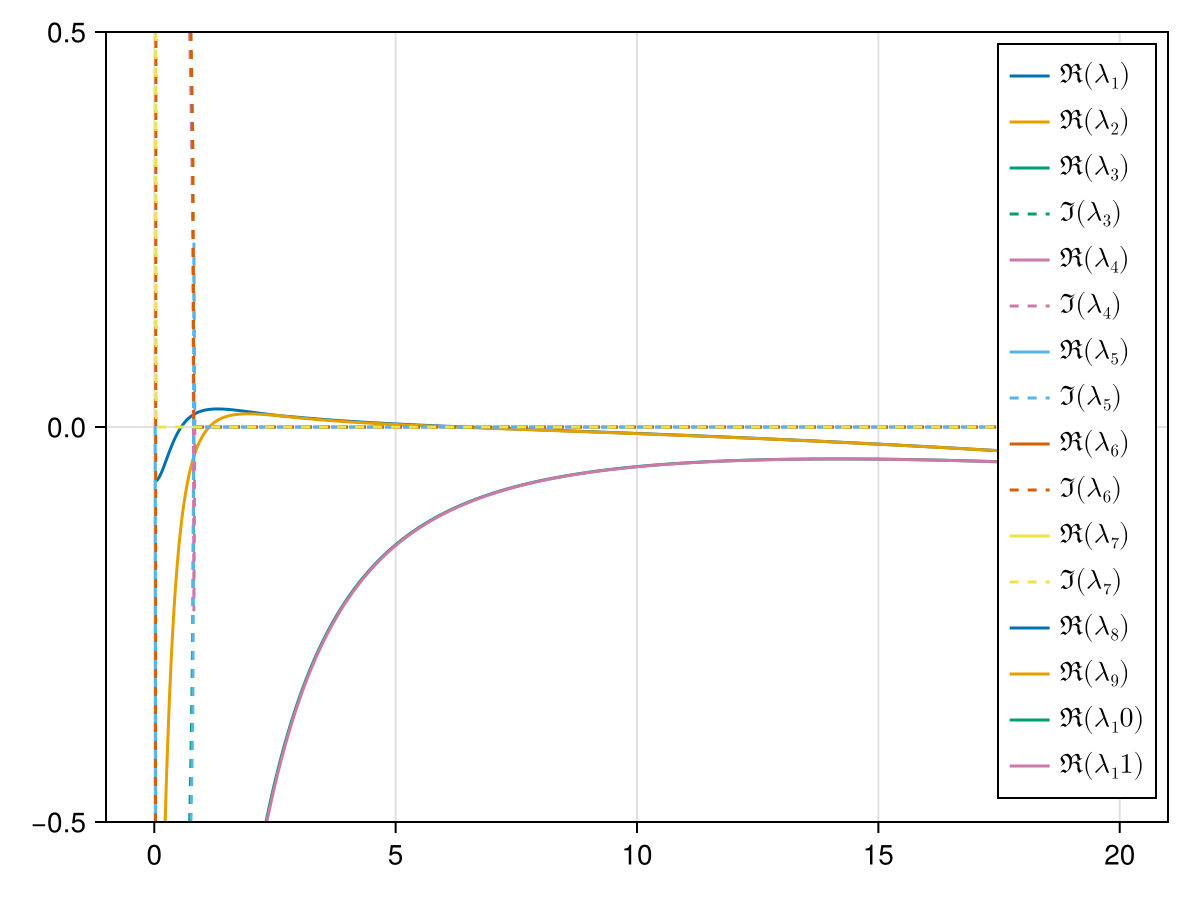

In [6]:
lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.5, 0.5))
#xlims!(faa.axis, (0., 2.))
faa

In [7]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(66, 1.3013013013013013)

In [8]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

11-element Vector{Float64}:
 -0.5424629824539635
 -0.45342572774807083
  0.5424629824538512
  0.45342572774798356
  8.839106055537138e-16
 -0.0037205438823514035
 -0.007638546051719512
  0.0037205438823503445
  0.007638546051718838
 -0.008175099437874039
  0.008175099437873897

## Spatial stuff - 1D!

In [11]:
ssize = (1000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.02, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 100000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((11, 1000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.02]))

#### Direct solver

  4.888196 seconds (923.41 k allocations: 3.604 GiB, 1.41% gc time)


ReturnCode.Success = 1

5683

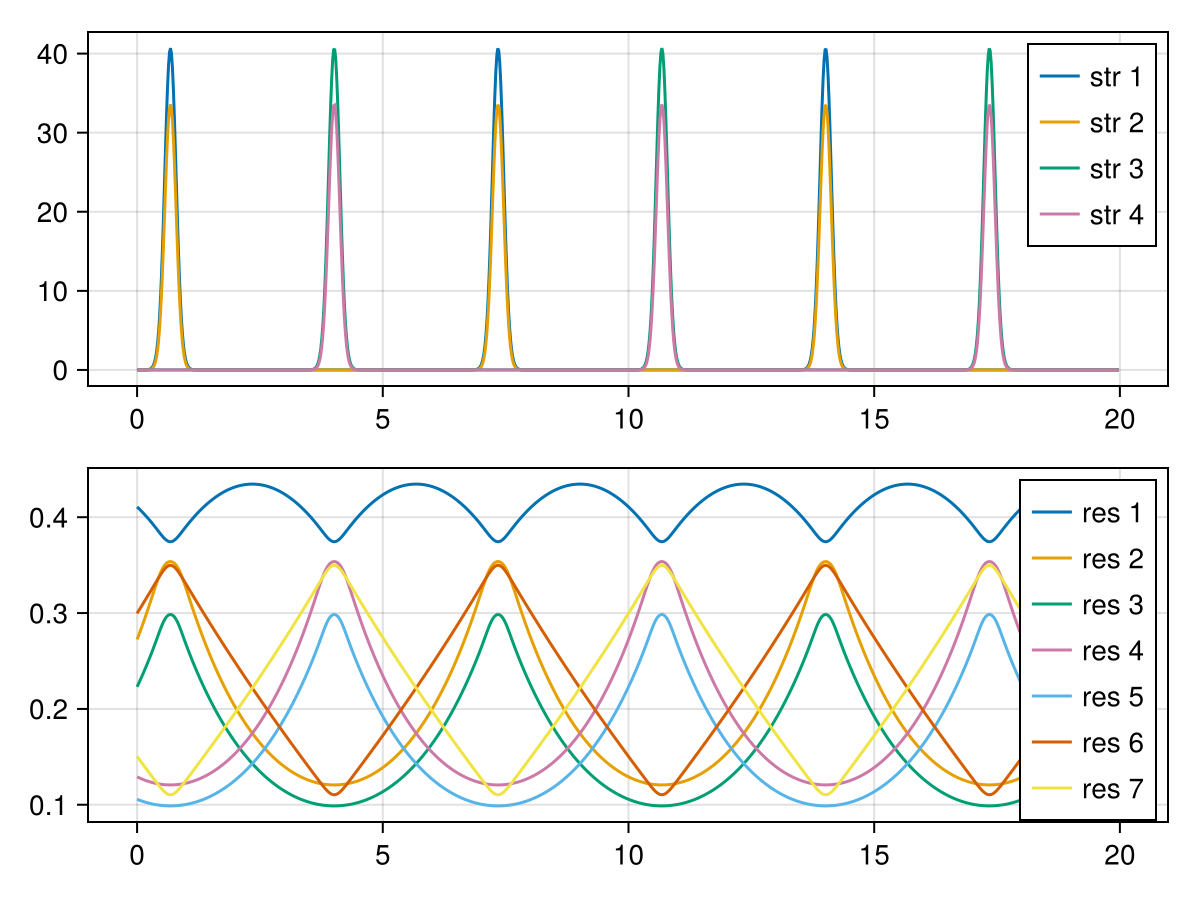

In [12]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

#### Steady state solver

 12.204321 seconds (836.84 k allocations: 2.199 GiB, 1.90% gc time)


ReturnCode.Success = 1

2803

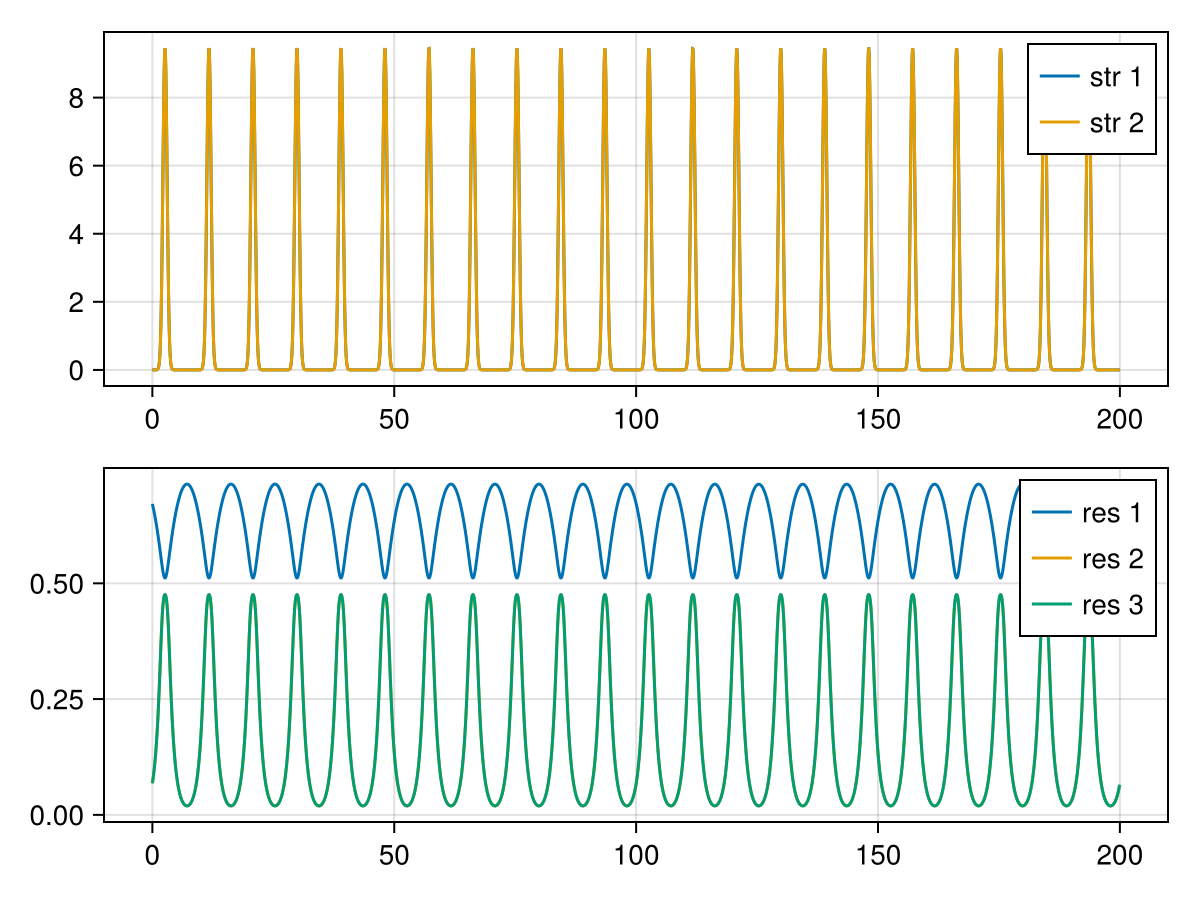

In [87]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

## Spatial stuff - 2D!

In [25]:
ssize = (10,10)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 1e-6)
space = make_cartesianspace_smart(length(ssize); dx=0.3, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 100, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((11, 10, 10), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.3, 0.3]))

#### Direct solver

In [ ]:
@time sps = solve(sp, Euler(); maxiters=1000000, dt=1e-4)
display(sps.retcode)
display(sps.destats.nf)
heatmap(sps.u[end][1,:,:])

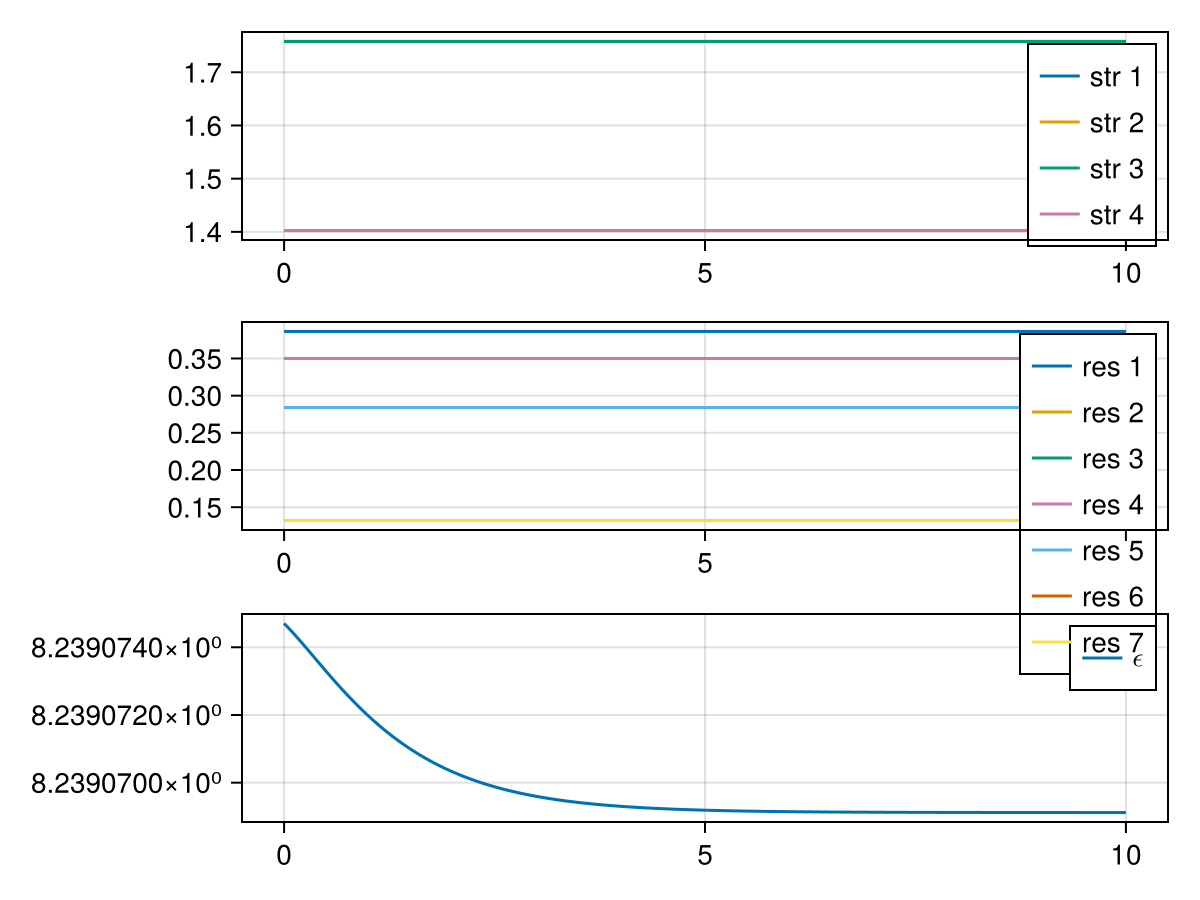

In [35]:
plot_smmicrm_sol_avgs(sps; plote=true)

In [134]:
@time sps = solve(sp, TRBDF2(); maxiters=1)
display(sps.retcode)
display(sps.destats.nf)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
#plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

LoadError: InterruptException:

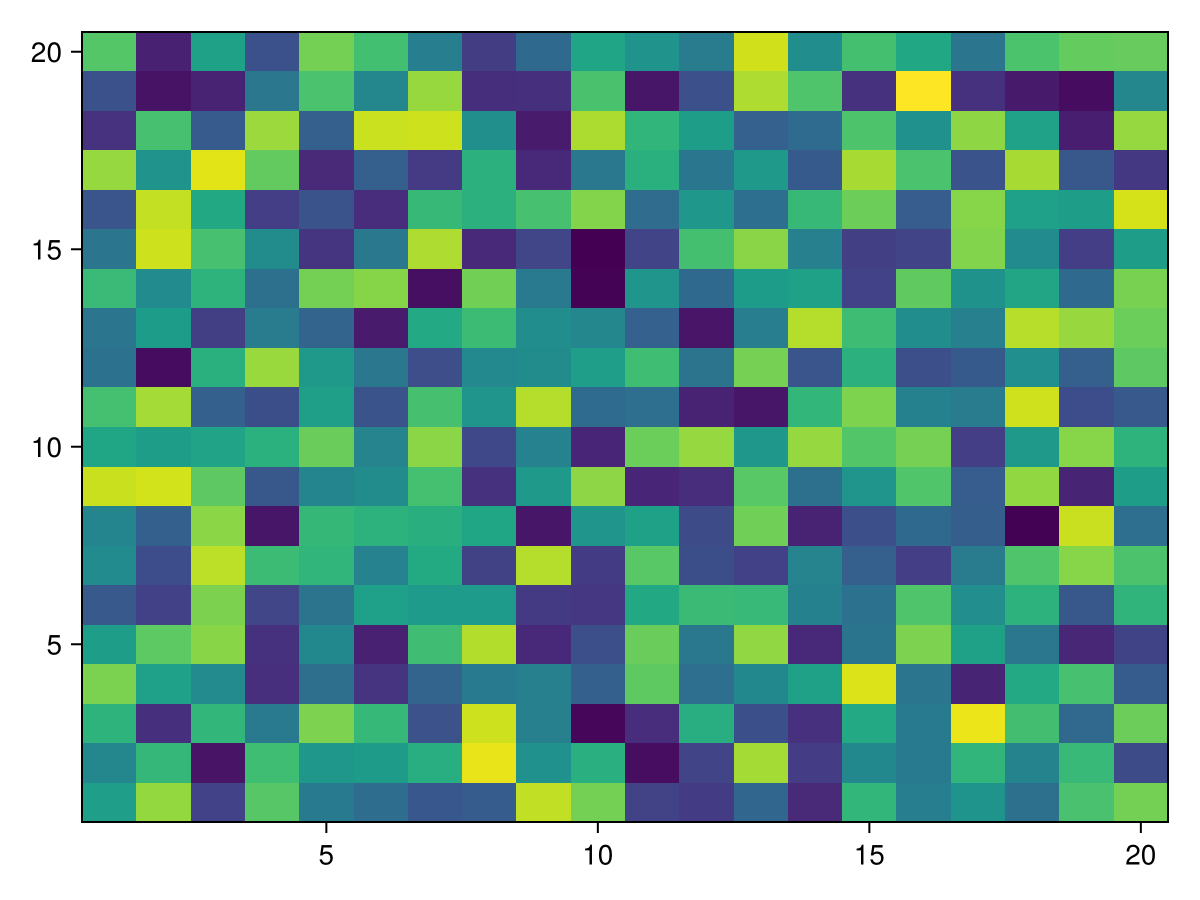

In [132]:
heatmap(sps.u[end][1,:,:])

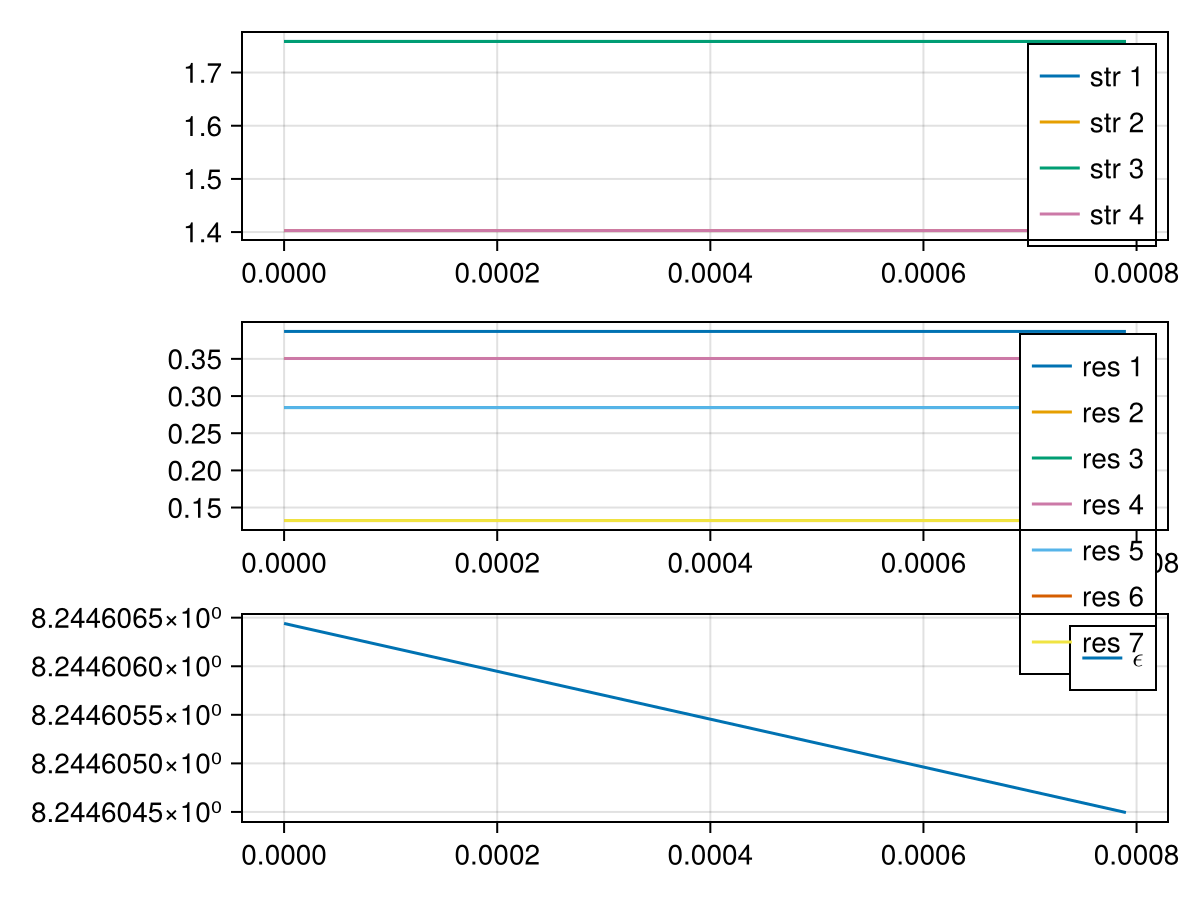

In [124]:
plot_smmicrm_sol_avgs(sps, 1:80; plote=true)

In [125]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  10001
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          10000
Number of rejected steps:                          0

# Extras

In [263]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()